In [7]:
import pandas as pd
import numpy as np

df=pd.read_csv('HNDB Progress Notes Processed.csv', index_col='date_of_service_dttm',parse_dates=True,error_bad_lines=False)

cols_to_keep=['mrn','filtered_HPI','Cancer_stage']
df=df[cols_to_keep]
df.columns=['mrn','HPI','Stage']

print (df.shape)
print (len(df.mrn.unique()))
df.head()

(7415, 3)
171


,mrn,HPI,Stage
date_of_service_dttm,,,
1978-01-01,3486779,Quit date: 1/1/1978.,NaN
2012-11-01,3486779,-- November 2012 noticed in right neck.,NaN
2013-02-01,3486779,-- Jan--Feb 2013 cisplatin based chemoradiatio...,NaN
2014-09-01,3486779,-- 9/2014 Noticed pain right hip -- noticed to...,NaN
2014-10-01,3486779,-- Oct 2014 surgery with rod placement per Dr....,NaN


In [8]:
### get ride of quit date notes

import re

def aboutQuitDate(para):
    try:
        search=re.search(r'[Qq]uit [Dd]ate',para)
        if search:
            return True
        else:
            return False
    except:
        return False
    
df=df[df['HPI'].apply(lambda p: not aboutQuitDate(p))]
df=df.sort_index()
### get unique mrns
unique_mrns=df.mrn.unique()
#create list of dataframes - each represents an mrn
ptx_info=[]
for mrn in unique_mrns:
    df_sub=df[df.mrn==mrn]
    ptx_info.append(df_sub)
    
df_rebuilt=''
for index,ptx in enumerate(ptx_info):
    if index==0:
        df_rebuilt=ptx_info[0]
    else:
        df_rebuilt=df_rebuilt.append(ptx)
df=df_rebuilt


print ('Notes without quit date:',df.shape[0])


Notes without quit date: 7397


In [9]:
### get unique mrns
unique_mrns=df.mrn.unique()
print (len(unique_mrns))

#create list of dataframes - each represents an mrn
ptx_info=[]

for mrn in unique_mrns:
    df_sub=df[df.mrn==mrn]
    ptx_info.append(df_sub)

print ('Num of patients:',len(ptx_info))

171
Num of patients: 171


In [10]:
from datetime import datetime,timedelta
### sort the entries in each df by date
for index,ptx in enumerate(ptx_info):
    ptx_info[index]=ptx_info[index].sort_index(ascending=True)

### add col to each df - time since intake

import datetime as dt

def time_elapsed(start_date,current_date):
    '''get difference between two datetimes'''
    time=current_date-start_date
    return time

def times_elapsed(df):
    '''from a sorted df with a datetime index get a list of how many days it has been since 1st encounter'''
    start_date=df.index[0].to_pydatetime()
    times=[]
    for index,row in df.iterrows():
        current_date=index.to_pydatetime()
        time=time_elapsed(start_date,current_date)
        times.append(time.days)
    return times

# print('\n')
# start=df_1.index[0].to_pydatetime()
# end=df_1.index[-1].to_pydatetime()
# print (start,end)
# print (time_elapsed(start,end))
# print (times_elapsed(df_1))

for index,df in enumerate(ptx_info):
    ptx_info[index]['days_elapsed']=times_elapsed(df)

### remake big csv and export to workplace.csv
df_rebuilt=''
for index,ptx in enumerate(ptx_info):
    if index==0:
        df_rebuilt=ptx_info[0]
    else:
        df_rebuilt=df_rebuilt.append(ptx)
df_rebuilt.to_csv('workplace.csv')
print ('number notes:',df_rebuilt.shape[0])
print ('number ptx',len(df_rebuilt.mrn.unique()))

number notes: 7397
number ptx 171


In [11]:
from nltk import tokenize
import re
def hasNegativeLanguage(sentence):
    '''check if a sentence expresses negative language'''
    pattern=r'[Nn]o |[Nn][Ee][Dd]|[Ww]ithout|does not have|[Ss]uspicious|concerned about|negative|lack of|(likely|may) represent'
    search=re.search(pattern,sentence)
    flag=False
    if search:
        flag=True
    return flag
def hasRMLanguage(sentence):
    '''check if a sentence indicates a recurrent tumor or metastasis'''
    flag=False
    search=re.search(r'[Rr]ecurrence|[Rr]ecurrent|[Mm]et(s|astatic|astas[ie]s)|[Pp]alliative chemo|[Pp]embro|[Nn]ivo(lumab)? |anti-PD(L)?1|EXTREME|[Gg]row(th|ing)|[Pp]rogress(ing|ive)|[Oo]ligomet|[Nn]odule|[Ee]nhancing|re(\-){1,2}excision|[Ss]pread|[Rr]esidual|[Pp]ersistent',sentence)
    if search and not hasNegativeLanguage(sentence):
        flag=True
    return flag
def isRM(para):
    '''determines if a paragraph has mention of a sentence that would indicate RM; takes optional input of last state - 
    previous recurrence indicates current status of True'''
    try:
        flag=False
        sentences=tokenize.sent_tokenize(para)
        for sentence in sentences:
            if hasRMLanguage(sentence):
                flag=True
        return flag
    except:
        return False

### add new columns RM_lang_flag and isRM - isRM takes into account previous results as is more useful
for index,ptx in enumerate(ptx_info):
    ptx_info[index]['RM_lang_flag']=ptx_info[index]['HPI'].apply(isRM)
    RM_flags=[]
    contains_true=False
    for i,row in ptx_info[index].iterrows():
        if row['RM_lang_flag']==False and contains_true==False:
            RM_flags.append(False)
        else:
            contains_true=True
            RM_flags.append(True)
    ptx_info[index]['is_RM']=RM_flags
    ptx_info[index]['is_RM']=ptx_info[index]['is_RM'].astype(int)
    
    ### to test new column output
    #print (RM_flags)
    
df_rebuilt=''
for index,ptx in enumerate(ptx_info):
    if index==0:
        df_rebuilt=ptx_info[0]
    else:
        df_rebuilt=df_rebuilt.append(ptx)
df_rebuilt.to_csv('workplace.csv')

### for RM calssifiaction validation
df_notes_w_recur=df_rebuilt[df_rebuilt.RM_lang_flag==True]
print('mrns with recur:',df_notes_w_recur.mrn.unique())
mrns_all=df_rebuilt.mrn.unique()
mrns_recur=df_notes_w_recur.mrn.unique()
l=[]
for mrn in mrns_all:
    if not mrn in mrns_recur:
        l.append(mrn)
print('mrns without recur:',l)
percent_recur=len(df_notes_w_recur.mrn.unique())/len(df_rebuilt.mrn.unique())*100
print('Percent ptx that are recurrent:',percent_recur)

mrns with recur: [2050963 2460803 2714226 2209904 3535060 2107646 3447609 3212148 3382796
 2849915 2933746 3290497 2975979 2979285 3054505 2975703 3659799 3162335
 2903558 3439308 3074909 1420705 3085711 3105416 3123549 3580291 3423189
 3256241 2573707 3163558 3165977 3542051 3156002 3148181 3151830 2958683
 3345169 3252015 1504532 3249882 3497403 3244910 3288379 3191617 3199771
 3192729 3221015 3292860 3307560 3260592 3415365 3452129 3259252 3251064
 1566343 1868643 3272590 3289711 3171632 3134848 3232866 2913559 3261049
 3276187 3279359 3205487 3305006 3735514 3385495 3301890 3486779 2994570
 3309751 3382952 3324677 3331397 3375948 3372233 3448959 3028615 3351990
 3351851 3437803 2743967 3442639 3361810 3444300 2840501 3142993 3470980
 3390635 3480615 3546446 3418273 3421057 3497326 3370728 3327545 3513634
 3453332 3523447 3519179 3503434  852008 3497265 2910738 3507074 3567685
 3503535 3317572 3503678 3496132 3506201 3511774 3667934 3521040 3525788
 3522111 3543765 3555469 2929012 3

7397


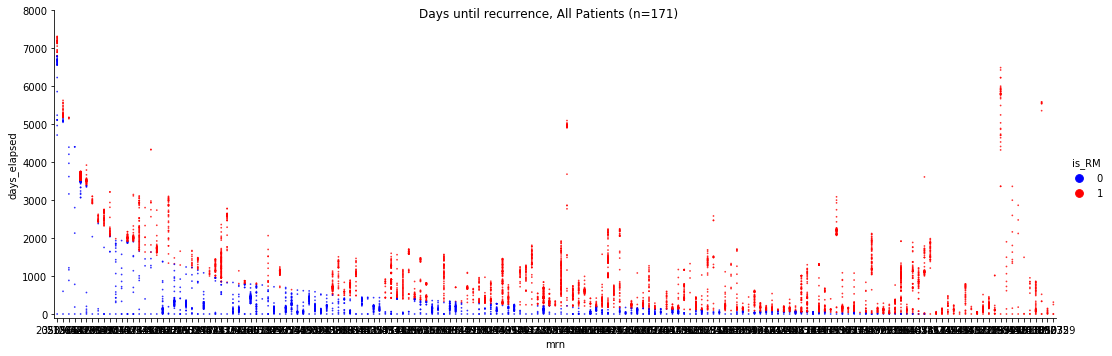

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


df=df_rebuilt.reindex()
print (df.shape[0])

## sort df by patient in ascending order of days_elapsed, default is ascending=True
# d={}
# counts=[]
# for mrn in df.mrn.unique():
#     df_sub=df[df.mrn==mrn]
#     try:
#         d[mrn]=df_sub.iloc[-1].days_elapsed-df_sub.iloc[0].days_elapsed
#     except:
#         d[mrn]=0
# for index,row in df.iterrows():
#     counts.append(d[row['mrn']])
# df['rank_order']=counts
# df=df.sort_values(by='rank_order',ascending=False)
# order=df.mrn.unique()
d={}
counts=[]
for mrn in df.mrn.unique():
    df_sub=df[df.mrn==mrn]
    if df_sub.iloc[0]['is_RM']==1:
        d[mrn]=-1
    else:
        start=df_sub.iloc[0].days_elapsed
        end=df_sub.iloc[-1].days_elapsed
        keep_going=True
        for index,row in df_sub.iterrows():
            if keep_going and row['is_RM']==1:
                keep_going=False
                end=row['days_elapsed']
        d[mrn]=end-start
for index,row in df.iterrows():
    counts.append(d[row['mrn']])
df['rank_order']=counts
df=df.sort_values(by='rank_order',ascending=False)
order=df.mrn.unique()


df_working=df
#df_working['mrn']=df_working['mrn'].astype(str)
grid=sns.catplot(x='mrn', y="days_elapsed", hue="is_RM", palette={0:'Blue',1:'Red'},jitter=False, 
                 **{'alpha':.8,'s':1.75},data=df_working, height=5, aspect=3,order=order)
grid.set(ylim=(-100,8000))
grid.fig.suptitle('Days until recurrence, All Patients (n='+str(len(ptx_info))+')')
plt.savefig('recurrence_timeline_all_patients.png')


### create a sub-df that will help contextualize this timeline within the context of all ptx encounters
cols=['mrn','is_RM']
df_to_export=df_rebuilt[cols]
df_to_export.to_csv('RM_MCs.csv')

In [13]:
def is_recur_patient(df):
    '''determines if a patient is recurrent by iterating through the is_RM field, returning boolean'''
    try:
        flag=False
        for index,row in df.iterrows():
            if row['is_RM']==1:
                flag=True
        return flag
    except:
        return False

ptx_info=[]
unique_mrns=df_working.mrn.unique()
for mrn in unique_mrns:
    df_sub=df_working[df_working['mrn']==mrn]
    ptx_info.append(df_sub)
for index,ptx in enumerate(ptx_info):
    group='Misc'
    for i,row in ptx.iterrows():
        stage=row['Stage']
        if group=='Misc':
            if stage=='I':
                group="Misc"
            elif stage=='II':
                group="Misc"
            elif stage=='III':
                group="III"
            elif stage=='IVa':
                group="IVa"
            elif stage=='IVb':
                group="IVb"
            elif stage=='IVc':
                group="Mets"
            else:
                group='Misc'
    ptx_info[index]['group']=group
    ### now see if recur patient
    ptx_info[index]['is_recur_patient']=is_recur_patient(ptx_info[index])
df_rebuilt=''
for index,ptx in enumerate(ptx_info):
    if index==0:
        df_rebuilt=ptx_info[0]
    else:
        df_rebuilt=df_rebuilt.append(ptx)


# grid=sns.catplot(x='mrn', y="days_elapsed", hue="is_RM", palette={0:'Blue',1:'Red'},jitter=False,
#                  **{'alpha':.8,'s':1.75},data=df_rebuilt, height=5, aspect=2.5,order=order,col='group',
#                  col_wrap=2,col_order=['IVa/b','Mets','III','Misc'])
# grid.set(ylim=(-100,8000))
# plt.savefig('recurrence_timeline_by_stage.png')


C:\Users\12488\python\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\12488\python\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['mrn', 'HPI', 'Stage', 'days_elapsed', 'RM_lang_flag', 'is_RM',
       'rank_order', 'group', 'is_recur_patient'],
      dtype='object')
Cannot generate graph for IVb no_recur
Cannot generate graph for Mets no_recur
Cannot generate graph for Mets recur


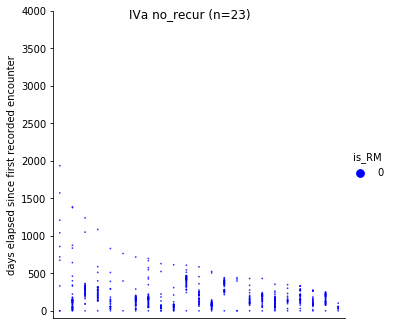

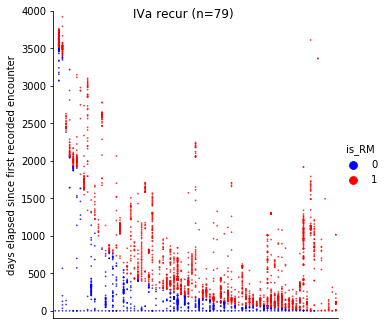

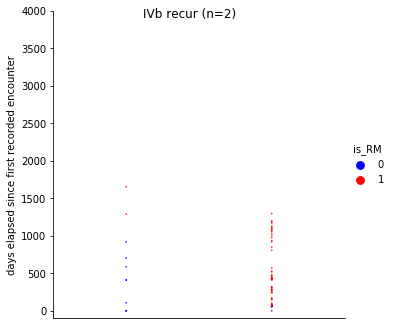

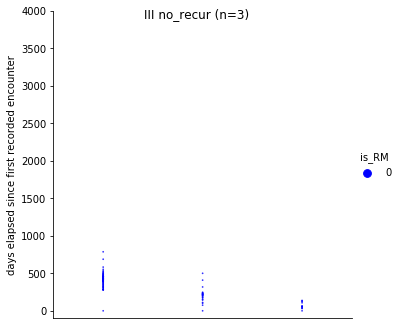

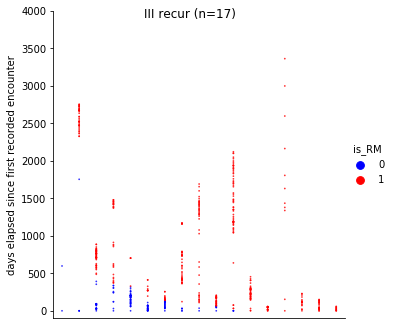

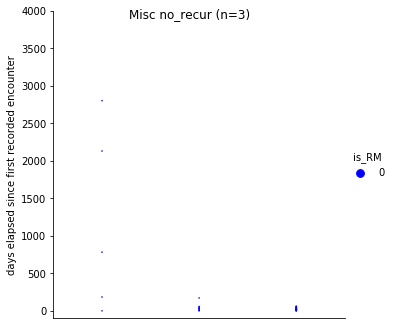

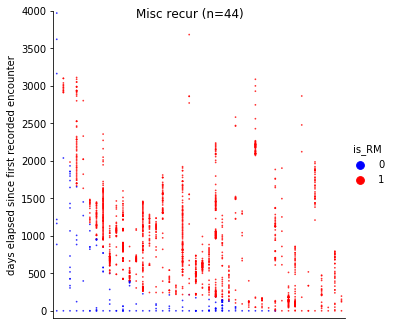

In [14]:
print (df_rebuilt.columns)
def graph_patient(df,title='',fig_name=None):
    df=df.sort_values(by='rank_order',ascending=False)
    order=df.mrn.unique()
    
#     grid=sns.catplot(x='mrn', y="days_elapsed", hue="is_RM", palette={0:'Blue',1:'Red'},jitter=False,
#                  **{'alpha':.8,'s':1.75},data=df, height=5, aspect=1,order=order,col='is_recur_patient',
#                  col_wrap=2,col_order=[False,True])
    grid=sns.catplot(x='mrn', y="days_elapsed", hue="is_RM", palette={0:'Blue',1:'Red'},jitter=False,
                 **{'alpha':.8,'s':1.75},data=df, height=5, aspect=1,order=order)
    grid.set(ylim=(-100,4000))
    grid.set(xlabel='',ylabel='days elapsed since first recorded encounter')
    grid.set(xticks=[])
    
    grid.fig.suptitle(title+' (n='+str(len(df['mrn'].unique()))+')')
    if fig_name != None:
        plt.savefig(fig_name)

patients_by_stage=[]
stages=['IVa','IVb','Mets','III','Misc']
for s in stages:
    sub_df=df_rebuilt[df_rebuilt['group']==s]
    sub_df1=sub_df[sub_df['is_recur_patient']==False]
    t1=s+' no_recur'
    sub_df2=sub_df[sub_df['is_recur_patient']==True]
    t2=s+' recur'
    t1=t1.replace('/','-')
    t2=t2.replace('/','-')
    try:
        graph_patient(sub_df1,title=t1,fig_name=t1+'.png')
    except:
        print('Cannot generate graph for',t1)
    try:
        graph_patient(sub_df2,title=t2,fig_name=t2+'.png')
    except:
        print('Cannot generate graph for',t2)